In [7]:
import re
import pandas as pd

df_selected = pd.read_csv("/Users/vatsal/Desktop/SimplyTag/selected_data.csv", low_memory=False)

# Step 3: Convert Data Types
df_selected['timestamp'] = pd.to_datetime(df_selected['Timestamp'], errors='coerce')
# Step 3: Convert Data Types
# Replace non-numeric or missing values with -1
df_selected['HTTP Status Code'] = pd.to_numeric(df_selected['HTTP Status Code'], errors='coerce').fillna(-1)

# Convert to integer after handling missing/non-numeric values
df_selected['status'] = df_selected['HTTP Status Code'].astype(int)

# Verify the conversion worked
print(df_selected['status'].unique())

# Step 4: Feature Engineering
# Add a flag for potential breaches (status 200 on unusual paths)
df_selected['is_breach'] = (df_selected['status'] == 200)

# Calculate request counts per trace ID
request_counts = df_selected.groupby('Trace-id').size().reset_index(name='request_count')

# Calculate error counts (404) per trace ID
error_counts = df_selected[df_selected['HTTP Status Code'] == 404].groupby('Trace-id').size().reset_index(name='error_count')

# Step 5: Aggregations
# Join metrics back to the main dataframe
metrics_df = pd.merge(df_selected, request_counts, on='Trace-id', how='left')
metrics_df = pd.merge(metrics_df, error_counts, on='Trace-id', how='left', suffixes=('', '_404'))

# Replace NaN in aggregated columns with 0
metrics_df.fillna({'error_count': 0}, inplace=True)

# Step 6: Save Transformed Data
output_file_path = '/Users/vatsal/Desktop/SimplyTag/transformed_logs.csv'
metrics_df.to_csv(output_file_path, index=False)

print(f"Transformed log data saved to: {output_file_path}")

[ -1 200 404 401 204 400 201   0 500 301 503 415 202 409 499 403]
Transformed log data saved to: /Users/vatsal/Desktop/SimplyTag/transformed_logs.csv


In [13]:
# Load the transformed logs CSV
transformed_logs_path = '/Users/vatsal/Desktop/SimplyTag/transformed_logs.csv'
logs_df = pd.read_csv(transformed_logs_path)
logs_df.head()

,Timestamp,Trace-id,HTTP Status Code,Path,User Agent,timestamp,status,is_breach,request_count,error_count
0,2024-11-29T23:00:22.7045112Z,3dff50eaf246e6cc55173db4092d5187,-1.0,NaN,NaN,2024-11-29 23:00:22.704511200+00:00,-1,False,13.0,0.0
1,2024-11-29T23:00:22.7065968Z,3dff50eaf246e6cc55173db4092d5187,-1.0,/api/v2/versions,check_http/v2.4.0 (monitoring-plugins 2.4.0),2024-11-29 23:00:22.706596800+00:00,-1,False,13.0,0.0
2,2024-11-29T23:00:22.7104302Z,3dff50eaf246e6cc55173db4092d5187,-1.0,NaN,NaN,2024-11-29 23:00:22.710430200+00:00,-1,False,13.0,0.0
3,2024-11-29T23:00:22.7112929Z,3dff50eaf246e6cc55173db4092d5187,-1.0,NaN,NaN,2024-11-29 23:00:22.711292900+00:00,-1,False,13.0,0.0
4,2024-11-29T23:00:22.7124052Z,3dff50eaf246e6cc55173db4092d5187,-1.0,NaN,NaN,2024-11-29 23:00:22.712405200+00:00,-1,False,13.0,0.0


In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd

# Load the transformed logs CSV
transformed_logs_path = '/Users/vatsal/Desktop/SimplyTag/transformed_logs.csv'
logs_df = pd.read_csv(transformed_logs_path)

# Step 1: Feature Selection
features = logs_df[['User Agent', 'status', 'request_count', 'error_count']]

# Step 2: Encode User Agent with TF-IDF
features['User Agent'] = features['User Agent'].fillna("unknown")
vectorizer = TfidfVectorizer(max_features=50)
user_agent_features = vectorizer.fit_transform(features['User Agent']).toarray()

# Step 3: Combine with Other Features
numerical_features = features[['status', 'request_count', 'error_count']].values
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(numerical_features)

# Combine all features
final_features = pd.concat([
    pd.DataFrame(user_agent_features),
    pd.DataFrame(scaled_numerical_features)
], axis=1)

# Step 4: K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters
clusters = kmeans.fit_predict(final_features)

# Add clusters to the original DataFrame
logs_df['cluster'] = clusters

# Step 5: Save Clustered Data
logs_df.to_csv('/Users/vatsal/Desktop/SimplyTag/clustered_logs.csv', index=False)
print("Clustered data saved to /mnt/data/clustered_logs.csv")


<ipython-input-18-d35ed01f3c08>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['User Agent'] = features['User Agent'].fillna("unknown")


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Load the transformed logs CSV
transformed_logs_path = '/Users/vatsal/Desktop/SimplyTag/transformed_logs.csv'
logs_df = pd.read_csv(transformed_logs_path)

# Step 1: Feature Selection
features = logs_df[['User Agent', 'status', 'request_count', 'error_count']]

# Step 2: Encode User Agent with TF-IDF
# Handle NaN values in 'User Agent'
features.loc[:, 'User Agent'] = features['User Agent'].fillna("unknown")

vectorizer = TfidfVectorizer(max_features=50)
user_agent_features = vectorizer.fit_transform(features['User Agent']).toarray()

# Step 3: Scale Numerical Features
# Handle NaN or infinite values in numerical columns
numerical_features = features[['status', 'request_count', 'error_count']].replace([np.inf, -np.inf], np.nan)
numerical_features = numerical_features.fillna(0)  # Replace NaN with 0
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(numerical_features)

# Combine all features into a single DataFrame
final_features = pd.concat([
    pd.DataFrame(user_agent_features),
    pd.DataFrame(scaled_numerical_features)
], axis=1).reset_index(drop=True)

# Check for invalid values in the combined features
if not np.isfinite(final_features).all().all():
    print("Invalid values found in final features. Please investigate.")
    final_features = final_features.replace([np.inf, -np.inf], 0).fillna(0)

# Step 4: K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters
clusters = kmeans.fit_predict(final_features)

# Add clusters to the original DataFrame
logs_df['cluster'] = clusters

# Step 5: Save Clustered Data
output_path = '/Users/vatsal/Desktop/SimplyTag/clustered_logs.csv'
logs_df.to_csv(output_path, index=False)
print(f"Clustered data saved to {output_path}")


/Users/vatsal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Clustered data saved to /Users/vatsal/Desktop/SimplyTag/clustered_logs.csv


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Prepare Labeled Data
logs_df['is_malicious'] = logs_df['is_breach']  # Use existing flag or add manual labels
X = final_features  # Features from clustering
y = logs_df['is_malicious']  # Target variable

# Step 2: Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Step 3: Train Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 4: Test Classifier
y_pred = clf.predict(X_test)

# Step 5: Evaluate Model
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[568127      0]
 [     0  75195]]

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00    568127
        True       1.00      1.00      1.00     75195

    accuracy                           1.00    643322
   macro avg       1.00      1.00      1.00    643322
weighted avg       1.00      1.00      1.00    643322



In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

# Load the transformed logs CSV
transformed_logs_path = '/Users/vatsal/Desktop/SimplyTag/transformed_logs.csv'
logs_df = pd.read_csv(transformed_logs_path)

# Step 1: Feature Selection
features = logs_df[['User Agent', 'status', 'request_count', 'error_count']]

# Step 2: Encode User Agent with TF-IDF
# Handle NaN values in 'User Agent'
features.loc[:, 'User Agent'] = features['User Agent'].fillna("unknown")

vectorizer = TfidfVectorizer(max_features=50)
user_agent_features = vectorizer.fit_transform(features['User Agent']).toarray()

# Step 3: Scale Numerical Features
# Handle NaN or infinite values in numerical columns
numerical_features = features[['status', 'request_count', 'error_count']].replace([np.inf, -np.inf], np.nan)
numerical_features = numerical_features.fillna(0)  # Replace NaN with 0
scaler = StandardScaler()
scaled_numerical_features = scaler.fit_transform(numerical_features)

# Combine all features into a single DataFrame
final_features = pd.concat([
    pd.DataFrame(user_agent_features),
    pd.DataFrame(scaled_numerical_features)
], axis=1).reset_index(drop=True)

# Check for invalid values in the combined features
if not np.isfinite(final_features).all().all():
    print("Invalid values found in final features. Please investigate.")
    final_features = final_features.replace([np.inf, -np.inf], 0).fillna(0)

# Step 4: K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)  # Adjust the number of clusters
clusters = kmeans.fit_predict(final_features)

# Add clusters to the original DataFrame
logs_df['cluster'] = clusters

# Step 5: Save Clustered Data
output_path = '/Users/vatsal/Desktop/SimplyTag/clustered_logs.csv'
logs_df.to_csv(output_path, index=False)
print(f"Clustered data saved to {output_path}")


/Users/vatsal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Clustered data saved to /Users/vatsal/Desktop/SimplyTag/clustered_logs.csv


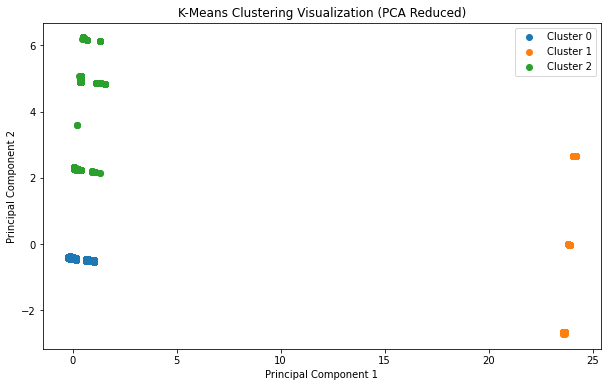

In [25]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Reduce Dimensions with PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions for visualization
reduced_features = pca.fit_transform(final_features)

# Step 2: Plot Clusters
plt.figure(figsize=(10, 6))
for cluster in set(clusters):
    cluster_points = reduced_features[logs_df['cluster'] == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

plt.title("K-Means Clustering Visualization (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()


In [27]:
import numpy as np

# Calculate distance from each point to its cluster centroid
centroids = kmeans.cluster_centers_
distances = np.linalg.norm(final_features - centroids[clusters], axis=1)

# Add distances to the DataFrame
logs_df['distance_from_centroid'] = distances

# Flag outliers based on a threshold (e.g., top 5% of distances)
logs_df['is_outlier'] = logs_df['distance_from_centroid'] > np.percentile(distances, 95)

# Save outliers for analysis
outliers_path = '//Users/vatsal/Desktop/SimplyTag/logs_outliers.csv'
logs_df[logs_df['is_outlier']].to_csv(outliers_path, index=False)

print(f"Outliers saved to: {outliers_path}")


Outliers saved to: //Users/vatsal/Desktop/SimplyTag/logs_outliers.csv
